In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
print(f'total words: {len(words)}')
print(f'total characters: {len("".join(words))}')
words[:5]

total words: 32033
total characters: 196113


['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# build vocabulary of characters and encoder/decoder (tokenizer)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(stoi)
print(f'{stoi=}')
print(f'{vocab_size=}')

stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
vocab_size=27


In [4]:
# build the dataset
block_size = 3          # context length

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            X.append(context)
            ix = stoi[ch]
            Y.append(ix)
            context = context[1:] + [ix]
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# utility fnction to compare Manual & PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()     # exact 
    app = torch.allclose(dt, t.grad)        # approx
    maxdiff = (dt - t.grad).abs().max().item()  # max separation
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')


In [6]:
n_embed = 10        # dimensionality of character embedding vectors 
n_hidden = 64       # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
# Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.1
b2 = torch.randn(vocab_size,                       generator=g) * 0.1
# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print('number of parameters in the model', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

number of parameters in the model 4137


In [7]:
batch_size = 32
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [51]:
# forward pass
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# Linear Layer 1
hprebn = embcat @ W1 + b1       # pre act, pre batch norm
# BatchNorm Layer
bnmeani = 1/batch_size * hprebn.sum(0, keepdims=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(batch_size-1) * bndiff2.sum(0, keepdims=True)    # Bessel's correction
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)
# Linear Layer 2
logits = h @ W2 + b2
# Cross entropy loss
logits_maxes = logits.max(1, keepdims=True).values
norm_logits = logits - logits_maxes     # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1         # to escape weired float point calculations
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()

# PyTorch back pass
for p in parameters:
    p.grad = None
for t in [
    logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits,
    logits_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff,
    bndiff2, hprebn, bnmeani, embcat, emb
]:
    t.retain_grad()
loss.backward()
loss

tensor(3.8239, grad_fn=<NegBackward0>)

In [52]:
# Manual back prop
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), Yb] = -1.0/batch_size

dprobs = (1. / probs) * dlogprobs

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

# first part: dcounts
dcounts = counts_sum_inv * dprobs

dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv

# second part: dcounts
dcounts += torch.ones_like(counts) * dcounts_sum

# dnorm_logits = norm_logits.exp() * dcounts
dnorm_logits = counts * dcounts

# first part: dlogits
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

# second part: dlogits
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

dhpreact = (1. - h**2) * dh

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

# first part: dbndiff
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar+1e-5)**-1.5) * dbnvar_inv

dbndiff2 = (1./(batch_size-1))*torch.ones_like(bndiff2) * dbnvar

# second part: dbndiff
dbndiff += (2*bndiff) * dbndiff2

# first part: dhprebn
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)

# second part: dhprebn
dhprebn += (1./batch_size)*torch.ones_like(dhprebn) * dbnmeani

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape)

dC = torch.zeros_like(C)

# for k in range(Xb.shape[0]):
#     for j in range(Xb.shape[1]):
#         ix = Xb[k,j]
#         dC[ix] += demb[k,j]
dC.index_add_(0, Xb.view(-1), demb.view(-1, 10))    # compact version of for loop
    
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logits_maxes', dlogit_maxes, logits_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bndiff', dbndiff, bndiff)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logits_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnraw           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bnbias  

In [53]:
# backprop through forward pass but efficiently

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast.item()-loss.item()))

dlogits = F.softmax(logits, 1)
dlogits[range(batch_size), Yb] -= 1
dlogits /= batch_size

cmp('logits', dlogits, logits)

3.8239028453826904 diff: 2.384185791015625e-07
logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [54]:
F.softmax(logits, 1)[0]

tensor([0.0114, 0.2017, 0.0166, 0.0328, 0.0601, 0.0169, 0.0098, 0.0129, 0.0323,
        0.0222, 0.0596, 0.0070, 0.0209, 0.0054, 0.0204, 0.0195, 0.0248, 0.0057,
        0.0021, 0.0161, 0.1435, 0.0426, 0.0747, 0.0135, 0.0041, 0.0603, 0.0631],
       grad_fn=<SelectBackward0>)

In [55]:
dlogits[0] * batch_size

tensor([ 0.0114, -0.7983,  0.0166,  0.0328,  0.0601,  0.0169,  0.0098,  0.0129,
         0.0323,  0.0222,  0.0596,  0.0070,  0.0209,  0.0054,  0.0204,  0.0195,
         0.0248,  0.0057,  0.0021,  0.0161,  0.1435,  0.0426,  0.0747,  0.0135,
         0.0041,  0.0603,  0.0631], grad_fn=<MulBackward0>)

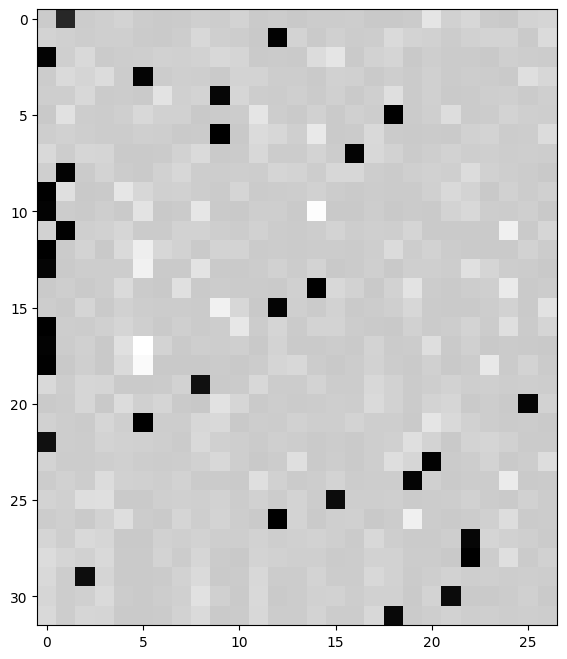

In [56]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [57]:
# backprop through batchnorm but efficiently
dhprebn = bngain*bnvar_inv/batch_size * (batch_size*dhpreact - dhpreact.sum(0) - batch_size/(batch_size-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


# 2-Layer MLP with compact code & worked out backprop

In [112]:
# def manual_grads(n, logits, Yb, C, W1, W2, bngain):
def manual_grads():
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1. - h**2) * dh
    # batchNorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/batch_size * (batch_size*dhpreact - dhpreact.sum(0) - batch_size/(batch_size-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer backprop
    dembcat = dhprebn @ W1.T 
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding 
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    # dC.index_add_(0, Xb.view(-1), demb.view(-1, 10))    # compact version of for loop
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
    return [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

In [119]:
n_embed = 10        # dimensionality of character embedding vectors 
n_hidden = 200       # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
# Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.1
b2 = torch.randn(vocab_size,                       generator=g) * 0.1
# BatchNorm parameters
bngain = torch.ones((1, n_hidden))*0.1 + 1.0
bnbias = torch.zeros((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print('number of parameters in the model', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


max_steps = 200000
batch_size = 32
n = batch_size
lossi = []

# use this context manager for efficiency once your backward pass is written
# with torch.no_grad():

# optimization
for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]       # batch X, Y

    # forward pass
    emb = C[Xb]             # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    # Linear Layer
    hprebn = embcat @ W1 + b1       # hidden layer pre-activaton
    # BatchNorm Layer
    # -----------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -----------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    # loss.backward()

    # manual backprop
    # -----------
    grads = manual_grads() # [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # ------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
        # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
        p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #     break


number of parameters in the model 12297
      0/ 200000: 3.8279
  10000/ 200000: 2.1609
  20000/ 200000: 2.4227
  30000/ 200000: 2.4362
  40000/ 200000: 2.0088
  50000/ 200000: 2.4084
  60000/ 200000: 2.4508
  70000/ 200000: 2.1090
  80000/ 200000: 2.3592
  90000/ 200000: 2.2353
 100000/ 200000: 1.9750
 110000/ 200000: 2.3438
 120000/ 200000: 2.0156
 130000/ 200000: 2.4772
 140000/ 200000: 2.3107
 150000/ 200000: 2.1108
 160000/ 200000: 1.9497
 170000/ 200000: 1.8004
 180000/ 200000: 2.0284
 190000/ 200000: 1.8848


In [ ]:
# check your gradients
# for p, g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

In [120]:
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [121]:
# evaluate train and val loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact-bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0673816204071045
val 2.1062190532684326


In [123]:
# my train loss:        2.0673816204071045
# my val loss:          2.1062190532684326

In [127]:
for _ in range(20):
    out = []
    context = [0] * block_size  # context length
    while True:
        # ----------------------------------
        # forward pass
        emb = C[torch.tensor([context])]    # embedding
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        # ----------------------------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

renix.
adeyani.
jozleigh.
wusef.
fam.
icie.
shubirshades.
qui.
eza.
jasiaw.
axfoon.
corie.
gibveli.
nyleen.
foody.
sii.
tro.
gla.
whalexxandreekrud.
xallu.
